*Giménez Arias, Carolina*

*Pons Suñer, Pedro*

## Series Temporales
El código desarrollado a continuación consiste en un consumidor que permite hacer un seguimiento temporal en tiempo real del número de menciones a cada partido. Para ello, consumirá información del consumidor-productor que transformaba determinadas palabras como por ejemplo los alias de cada partido en los nombres de sus respectivos partidos políticos para que el consumidor haga recuento y los plotee, tal y como se observa a continuación.

Los tweets son consumidos del topic *tweetsProcessed*, que son producidos en el script *ConsumerProducer*.

In [1]:
# Cargamos las librerías a usar:
import matplotlib.pyplot as plt
from confluent_kafka import Consumer, KafkaError
from IPython.display import display, clear_output
import pandas as pd
import matplotlib.dates as mdates
import datetime,re

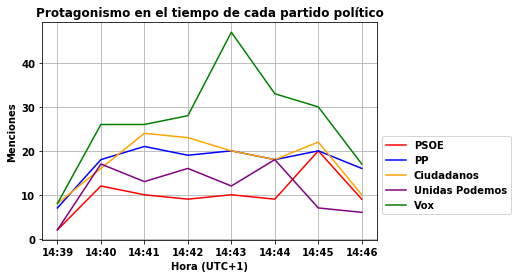

KeyboardInterrupt: 

In [34]:
cons2 = Consumer({
    'bootstrap.servers': 'localhost:9092',
    'group.id': 'mygroupTS',
})

cons2.subscribe(['tweetsProcessed'])
first_run=True
new_window=True
aver=True

while True:
    
    msg = cons2.poll(1.0) # espera un segundo, si en ese segundo nos llega algo lo usa

    if msg is None:
        continue
    tweet_info = msg.value().decode('utf-8')
    tweet_info=tweet_info.replace("\\\"","\"")
    if first_run == True:
        now = datetime.datetime.now()
        fechas_historico=[]
        psoe_historico=[]
        psoe=[]
        
        pp_historico = []
        pp = []
        
        cs_historico = []
        cs = []
        
        podemos_historico = []
        podemos = []
        
        vox_historico = []
        vox = []
        
        hours = mdates.SecondLocator(interval = 10) #cogeremos tweets cada 10 segundos
        date_formatter = mdates.DateFormatter('%H:%M:%S') #añadimos el formato en el que vamos a recoger las fechas
        
        #Creamos la figura donde plotearemos la evolución temporal
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1) 
        first_run = False 
    
    if new_window==True:
        time_tweets = pd.DataFrame()
        createdat = datetime.datetime.strptime(re.search("created_at\": (.*), \"country\":",tweet_info)[0][14:-13], '%Y-%m-%d %H:%M:%S') + datetime.timedelta(hours = 2)
        if createdat>now:
            time_tweets['texto'] = [re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10]]
            time_tweets['fecha'] =  [createdat]
            psoe.append(re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10].count('PSOE'))
            pp.append(re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10].count('PP'))
            cs.append(re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10].count('CIUDADANOS'))
            podemos.append(re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10].count('PODEMOS'))
            vox.append(re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10].count('VOX'))
            new_window=False
                
        else:
            continue
            
    if first_run == False: 
        createdat = datetime.datetime.strptime(re.search("created_at\": (.*), \"country\":",tweet_info)[0][14:-13], '%Y-%m-%d %H:%M:%S') + datetime.timedelta(hours = 2)
        time_tweets = pd.concat([time_tweets,pd.DataFrame({'texto':[re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10]],'fecha':[createdat]})])
    
    fechas = time_tweets['fecha']
    datemin = min(fechas)
    datemax = max(fechas)
    elapsed=datemax-datemin
    elapsed_s=elapsed.total_seconds()
    
    #Suma acumulada del número de veces que aparece cada palabra
    psoe.append(re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10].count('PSOE'))
    pp.append(re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10].count('PP'))
    cs.append(re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10].count('CIUDADANOS'))
    podemos.append(re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10].count('PODEMOS'))
    vox.append(re.search("text\": (.*), \"user\":",tweet_info)[0][8:-10].count('VOX'))
    
    if elapsed_s > 60:
        new_window=True
        for x in fechas:
            fechas_historico.append(x)
        idx=pd.DatetimeIndex(fechas_historico)
        for x in psoe:
            psoe_historico.append(x)
        for x in pp:
            pp_historico.append(x)
        for x in cs:
            cs_historico.append(x)
        for x in podemos:
            podemos_historico.append(x)
        for x in vox:
            vox_historico.append(x)
        
        # Creamos las series temporales para cada partido
        ts_psoe = pd.Series(psoe_historico,index=idx).resample('60S').sum()
        psoe = []
        
        ts_pp = pd.Series(pp_historico, index = idx).resample('60S').sum()
        pp = []
        
        ts_cs = pd.Series(cs_historico, index = idx).resample('60S').sum()
        cs = []
        
        ts_podemos = pd.Series(podemos_historico, index = idx).resample('60S').sum()
        podemos = []
        
        ts_vox = pd.Series(vox_historico, index = idx).resample('60S').sum()
        vox = []
        
        # Sacamos el plot
        ax.cla()
        fig, ax = plt.subplots()
        ax.grid(True)
        ax.set_title("Protagonismo en el tiempo de cada partido político")
        ax.set_xlabel("Hora (UTC+1)")
        date_formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_formatter)
        ax.set_ylabel("Menciones")

        ax.plot(ts_psoe, color="Red", label="PSOE")
        ax.plot(ts_pp, color="Blue", label="PP")
        ax.plot(ts_cs, color="Orange", label="Ciudadanos")
        ax.plot(ts_podemos, color="Purple", label="Unidas Podemos")
        ax.plot(ts_vox, color="Green", label="Vox")
        
        ax.legend(loc='best',bbox_to_anchor=(1, 0.5))
        display(fig)
        clear_output(wait = True)
        plt.pause(0.5)
    
cons2.close()